In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip drive/MyDrive/PhC-C2DH-U373.zip

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras import backend as K

In [ ]:
from PIL import Image

# Cargo Train y Val

Train será aumentado

Acá se importan las imágenes de train y de validación del zip que porvee la cátedra.

In [ ]:
train_path = Path("PhC-C2DH-U373/01/").glob("**/*tif")
val_path = Path("PhC-C2DH-U373/02/").glob("**/*tif")

In [ ]:
train_images = list()
train_masks = list()
for file in train_path:
    train_images.append(np.array(Image.open(file)).reshape(1,520,696))
    train_masks.append(np.array(Image.open(f'PhC-C2DH-U373/01_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

val_images = list()
val_masks = list()

for file in val_path:
    val_images.append(np.array(Image.open(file)).reshape(1,520,696))
    val_masks.append(np.array(Image.open(f'PhC-C2DH-U373/02_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

In [ ]:
train_images = np.vstack(train_images)/255
train_masks = 1*(np.vstack(train_masks) > 0)
val_images = np.vstack(val_images)/255
val_masks = 1*(np.vstack(val_masks) >0 )

# Imágenes de train sin aumentar

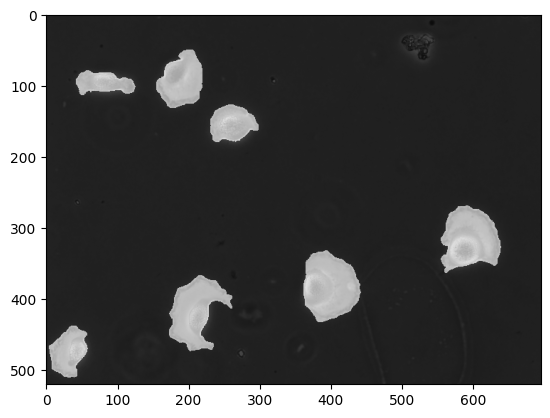

In [ ]:
idx = 100
plt.imshow(train_images[idx], vmin=0, vmax=1, cmap="gray")
plt.imshow(train_masks[idx], vmin=0, vmax=1, cmap="gray",alpha=0.6)
plt.show()

# Armo datasets de tensorflow y aumento

Para mantener sincronizada la aumentación entre la imagen y la máscara, armo una entrada de 4 canales que de descompondrán durante el entrenamiento.

In [ ]:
x_train = np.stack((train_images, train_masks ),axis=-1)
x_val = np.stack((val_images, val_masks ),axis=-1)

In [ ]:
x_train[0,:,:,0].max()

0.7294117647058823

In [ ]:
len(x_train)

115

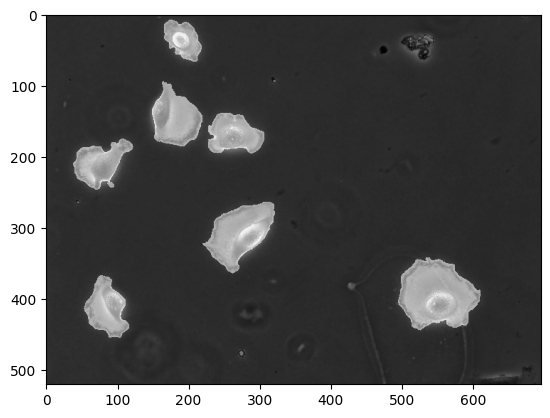

In [ ]:
plt.imshow(x_train[0,:,:,0], cmap="gray")
plt.imshow(x_train[0,:,:,1], cmap="gray", alpha = 0.5)

In [ ]:
from tensorflow.keras.models import Sequential

# Armo una red mínima fully convolutional con Atrous Convolutions

Primero, a modo de un test básico proponen una red mínima fully convolutional, con atrous convolutions. Las atrous convolutions permiten aumentar el receptive field sin sacrificar la extracción densa de características. De este modo tiene sentido crear una red fully convolutional con padding 'same', y con stride=1 a lo largo de la misma (es decir, sin reducir la dimensionalidad de la misma).

Del blog citado en clase (https://towardsdatascience.com/review-deeplabv3-atrous-convolution-semantic-segmentation-6d818bfd1d74):

(a) Sin Atrous Conv: se realizan conv estándar y pooling, lo que hace que el output stride de salida aumente, es decir, el output feature map sea más pequeño cuando se profundiza. Sin embargo, los strides consecutivss son perjudiciales para la segmentación semántica porque la información de ubicación/espacial se pierde en las capas más profundas.
(b) Con Atrous Conv: Con atrous conv, podemos mantener el stride constatnte pero con un mayor campo de visión sin aumentar el número de parámetros o la intensidad de cálculo. Y finalmente, podemos tener un mapa de características de salida más grande, lo que que es bueno para la segmentación semántica.

In [ ]:
filters = 16
kernel_size = 10
def get_red_seg():
    return Sequential([
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 1, input_shape = (None,None,1)),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 2),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 4),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 8),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 1),
        tf.keras.layers.Conv2D(1, kernel_size,padding="same", activation = "sigmoid", dilation_rate = 1)
    ])


# Armo la red de preprocesamiento para hacer aumentación en la GPU que no tengo

In [ ]:
def get_preproc():
    return Sequential([
        tf.keras.layers.RandomCrop(512,512),
        tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'),
        #tf.keras.layers.RandomZoom((-0.1,0.3)),
        #tf.keras.layers.RandomTranslation((-0.5, 0.5), (-0.5,0.5)),
        #tf.keras.layers.RandomRotation((0,1)),
        #tf.keras.layers.RandomZoom((0.5,0.5)),
        ])

def get_preproc_val():
    return Sequential([
        tf.keras.layers.CenterCrop(512,512),
        ])

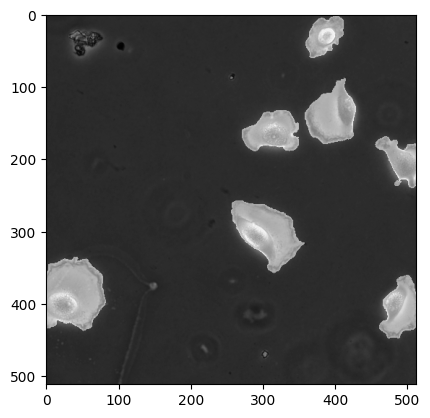

In [ ]:
preproc = get_preproc()
aux_elem = preproc(x_train[0])
plt.imshow(aux_elem[:,:,0], cmap="gray")
plt.imshow(aux_elem[:,:,1], cmap="gray", alpha = 0.5)

In [ ]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
class SegmentationModel(Model):
    def __init__(self, red_preproc, red_segmentacion, red_preproc_val):
        super().__init__()
        self.red_segmentacion = red_segmentacion
        self.red_preproc = red_preproc
        self.red_preproc_val = red_preproc_val
        self.loss_tracker = metrics.Mean(name="loss")
        self.dice = False


    def call(self, inputs):
        #img_mask = self.red_preproc = red_preproc(inputs)
        return self.red_segmentacion(inputs[:,:,:1])

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            data_aug = self.red_preproc(data)
            loss = self._compute_loss(data_aug)
            #print(K.mean(loss))

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.red_segmentacion.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.red_segmentacion.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        data_preproc = self.red_preproc_val(data)
        loss = self._compute_loss(data_preproc)
        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        #aux = self.red_preproc(data)
        mask_out = self.red_segmentacion(data[:,:,:,:1])
        #print(mask_out.shape)
        #print(data[:,:,:,1:2].numpy())
        if self.dice == True:
            loss = dice_loss(data[:,:,:,1:2], mask_out)
        else:
            loss = tf.keras.losses.binary_crossentropy(data[:,:,:,1:2], mask_out)
        return loss

    # property
    # def metrics(self):
    #     # We need to list our metrics here so the `reset_states()` can be
    #     # called automatically.
    #     return [self.loss_tracker]

En el siguiente código se ensambla una red fully convolutional utilizando trous convolutions. Las Atrous convolutions

In [ ]:
red_falopa = get_red_seg()

Implementación de la red con Atrous convolutions (ver comentario en la definición de la red)

In [ ]:
red_falopa.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 16)    1616      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 1)     1601      
                                                                 
Total params: 105,681
Trainable params: 105,681
Non-tr

In [ ]:
preproc= get_preproc()
preproc_val = get_preproc_val()
red_falopa = get_red_seg()
model = SegmentationModel(preproc, red_falopa,preproc_val)

In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

In [ ]:
len(x_val)

115

Se entrena a la red de Atrous convolutions (a.k.a. red folpa).

In [ ]:
model.fit(np.vstack([x_train, x_val]),batch_size=16, epochs=50, validation_split = 0.5, verbose = 1)

Epoch 1/50
8/8 [==============================] - 69s 2s/step - loss: 0.6940 - val_loss: 0.6893
Epoch 2/50
8/8 [==============================] - 8s 1s/step - loss: 0.6841 - val_loss: 0.6627
Epoch 3/50
8/8 [==============================] - 8s 1s/step - loss: 0.6341 - val_loss: 0.5192
Epoch 4/50
8/8 [==============================] - 8s 1s/step - loss: 0.4444 - val_loss: 0.1882
Epoch 5/50
8/8 [==============================] - 8s 1s/step - loss: 0.3722 - val_loss: 0.1811
Epoch 6/50
8/8 [==============================] - 8s 1s/step - loss: 0.3413 - val_loss: 0.2371
Epoch 7/50
8/8 [==============================] - 8s 1s/step - loss: 0.3472 - val_loss: 0.1931
Epoch 8/50
8/8 [==============================] - 8s 1s/step - loss: 0.3333 - val_loss: 0.2006
Epoch 9/50
8/8 [==============================] - 8s 1s/step - loss: 0.3259 - val_loss: 0.1950
Epoch 10/50
8/8 [==============================] - 8s 1s/step - loss: 0.3263 - val_loss: 0.1890
Epoch 11/50
8/8 [==============================]

In [ ]:
pred = red_falopa(x_val[0:1,:,:,0])
pred.shape

TensorShape([1, 520, 696, 1])

In [ ]:
pred.numpy().max()

0.9722711

A continuación vamos la performance con una imágen de prueba, que no es mala. Esto es de esperar porque se implementó una red fully convolutional de varias etapas. De acuerdo a lo visto en clase las redes fully convolutional tienen una performance razonable, pero como no se reduce la dimensionalidad su costo de computo es alto.

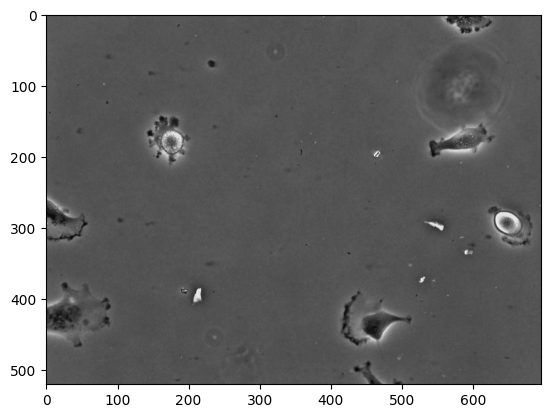

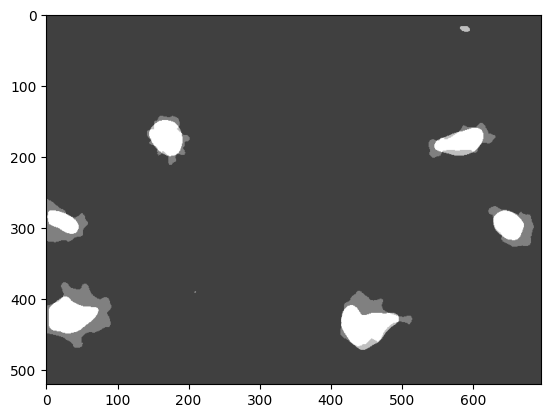

In [ ]:
plt.imshow(x_val[0,:,:,0], cmap="gray")
plt.show()
plt.imshow(x_val[0,:,:,1], cmap="gray", alpha=0.5)
plt.imshow(pred[0,:,:,0]>0.7, cmap="gray", alpha=0.5)
plt.show()

In [ ]:
pred = red_falopa(x_val[0:1,:,:,0])

val = x_val[0:1,:,:,1]
pred_casted = tf.cast((pred[0:1,:,:,0]>0.5), dtype=tf.double)

print(dice_coef(x_val[0:1,:,:,1], tf.cast((pred[0:1,:,:,0]>0.5), dtype=tf.double)))

#dice coef = 0.7740


tf.Tensor(0.7740460600650811, shape=(), dtype=float64)


A continuación se entrena una red UNET. De acuerdo a lo descripto en el paper original (https://arxiv.org/pdf/1505.04597.pdf) la arquitectura de la UNET consiste en un camino de codificacion y un camino de decodificacion. La ruta de codificacion sigue la arquitectura típica de una red convolucional. Consiste en la aplicación repetida de dos convoluciones de 3x3 (sin padding), cada una seguida de una relu y una operación de max pooling de 2x2 con stride 2 para el downsampleo. En downsampleo, duplicamos el número de canales de funciones. Cada paso en la ruta de decodificacion consiste en un upsampling del mapa de funciones seguido de una convolución de 2x2 ("convolución ascendente") que reduce a la mitad el número de canales de funciones, una concatenación con el mapa de funciones correspondientemente recortado de la ruta de contracción, y dos convoluciones 3x3, cada una seguida de una relu. Según los autores, el recorte es necesario debido a la pérdida de píxeles de borde en cada convolución. En la capa final, se usa una convolución de 1x1 para asignar cada vector de características de 64 componentes al número deseado de clases. En total la red tiene 23 capas convolucionales.

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Concatenate, MaxPooling2D, UpSampling2D,Conv2DTranspose

In [ ]:
img_shape = (512, 512, 1)
def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu',
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

In [ ]:
preproc_unet= get_preproc()
preproc_unet_val= get_preproc_val()
red_unet = UNet(
    img_shape,
    start_ch = 16,
    dropout = False,
    residual = True
)
model_unet = SegmentationModel(preproc_unet, red_unet,preproc_unet_val)

In [ ]:
model_unet.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

In [ ]:
import keras.backend as k
k.clear_session()
model_unet.fit(np.vstack([x_train, x_val]),batch_size=16, epochs=50, validation_split = 0.5, verbose = 1)

Epoch 1/50
8/8 [==============================] - 52s 3s/step - loss: 0.6518 - val_loss: 0.5938
Epoch 2/50
8/8 [==============================] - 12s 1s/step - loss: 0.5702 - val_loss: 0.4282
Epoch 3/50
8/8 [==============================] - 12s 1s/step - loss: 0.4004 - val_loss: 0.1866
Epoch 4/50
8/8 [==============================] - 12s 1s/step - loss: 0.3666 - val_loss: 0.2620
Epoch 5/50
8/8 [==============================] - 12s 1s/step - loss: 0.3512 - val_loss: 0.1989
Epoch 6/50
8/8 [==============================] - 14s 2s/step - loss: 0.3495 - val_loss: 0.2264
Epoch 7/50
8/8 [==============================] - 12s 1s/step - loss: 0.3438 - val_loss: 0.2010
Epoch 8/50
8/8 [==============================] - 14s 2s/step - loss: 0.3386 - val_loss: 0.2098
Epoch 9/50
8/8 [==============================] - 14s 2s/step - loss: 0.3343 - val_loss: 0.1983
Epoch 10/50
8/8 [==============================] - 12s 1s/step - loss: 0.3229 - val_loss: 0.1861
Epoch 11/50
8/8 [======================

In [ ]:
red_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 512, 512, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_13 (Conv2D)             (None, 512, 512, 16  2320        ['conv2d_12[0][0]']              
                                )                                                             

In [ ]:
aux = preproc_unet_val(x_val[0:1,0:,:,:])
pred = red_unet(aux[0:1,:,:,0])
pred.shape

val = x_val[0:1,:,:,1]
pred_casted = tf.cast((pred[0:10,:,:,0]>0.5), dtype=tf.float32)

print(x_val[0:1,:,:,1].shape)
print(pred_casted.shape)

print(dice_coef(aux[0:1,:,:,1], pred_casted))

#dice de 0.84079707 para la primer imagen
#solo tomo la primera porque si no collab me tira error, supongo que por el limite de memoria

(1, 520, 696)
(1, 512, 512)
tf.Tensor(0.84079707, shape=(), dtype=float32)


In [ ]:
pred.numpy().max()

0.99123085

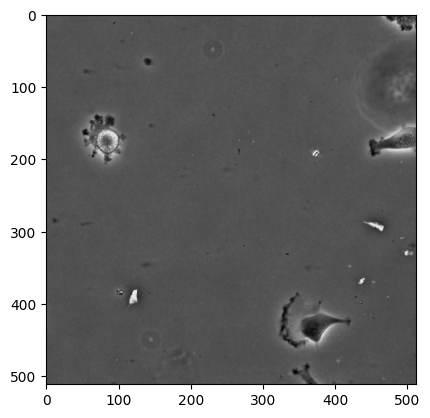

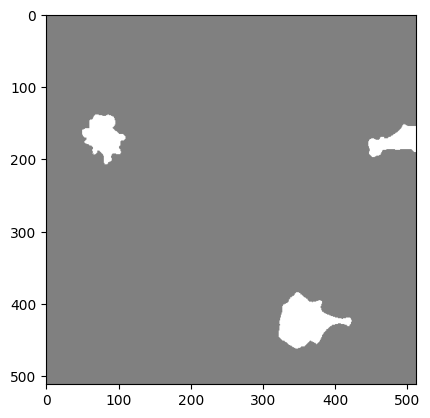

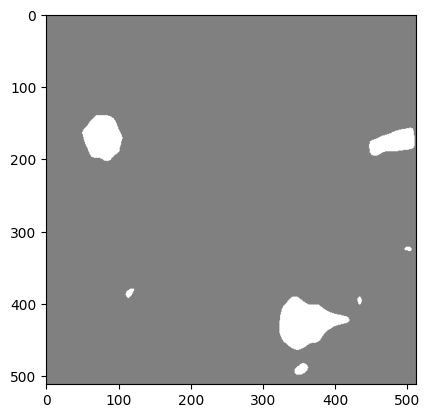

In [ ]:
plt.imshow(aux[0,:,:,0], cmap="gray")
plt.show()
plt.imshow(aux[0,:,:,1], cmap="gray", alpha = 0.5)
plt.show()
plt.imshow(pred[0,:,:,0]>0.7, cmap="gray", alpha = 0.5)
plt.show()

Ahora pruebo con más data augmentation si mejora el dice coefficient:

In [ ]:
def get_preproc_full():
    return Sequential([
        tf.keras.layers.RandomCrop(512,512),
        tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'),
        tf.keras.layers.RandomZoom((-0.1,0.3)),
        tf.keras.layers.RandomTranslation((-0.5, 0.5), (-0.5,0.5)),
        tf.keras.layers.RandomRotation((0,1)),
        tf.keras.layers.RandomZoom((0.5,0.5)),
        ])

def get_preproc_val_full():
    return Sequential([
        tf.keras.layers.CenterCrop(512,512),
        ])

In [ ]:
import keras.backend as K
K.clear_session()

preproc_unet= get_preproc_full()
preproc_unet_val= get_preproc_val_full()
red_unet = UNet(
    img_shape,
    start_ch = 16,
    dropout = False,
    residual = True
)
model_unet = SegmentationModel(preproc_unet, red_unet,preproc_unet_val)

model_unet.compile(optimizer= tf.keras.optimizers.Adam(1e-4))
model_unet.fit(np.vstack([x_train, x_val]),batch_size=16, epochs=50, validation_split = 0.5, verbose = 1)

Epoch 1/50
8/8 [==============================] - 23s 2s/step - loss: 0.6564 - val_loss: 0.6269
Epoch 2/50


ResourceExhaustedError: ignored

No puede fitearlo, era pedirle demasiado a la GPU gratuita de collab (out of memory error)

In [ ]:
K.clear_session()
red_falopa = get_red_seg()
preproc= get_preproc_full()
preproc_val = get_preproc_val_full()
red_falopa = get_red_seg()
model = SegmentationModel(preproc, red_falopa,preproc_val)
model.compile(optimizer= tf.keras.optimizers.Adam(1e-4))
model.fit(np.vstack([x_train, x_val]),batch_size=16, epochs=50, validation_split = 0.5, verbose = 1)

Epoch 1/50
8/8 [==============================] - 13s 1s/step - loss: 0.6464 - val_loss: 0.5160
Epoch 2/50
8/8 [==============================] - 9s 1s/step - loss: 0.4213 - val_loss: 0.1702
Epoch 3/50
8/8 [==============================] - 9s 1s/step - loss: 0.3456 - val_loss: 0.1821
Epoch 4/50
8/8 [==============================] - 9s 1s/step - loss: 0.3204 - val_loss: 0.2276
Epoch 5/50
8/8 [==============================] - 8s 1s/step - loss: 0.3119 - val_loss: 0.1793
Epoch 6/50
8/8 [==============================] - 8s 1s/step - loss: 0.3050 - val_loss: 0.1897
Epoch 7/50
8/8 [==============================] - 8s 1s/step - loss: 0.3044 - val_loss: 0.1872
Epoch 8/50
8/8 [==============================] - 8s 1s/step - loss: 0.3176 - val_loss: 0.1877
Epoch 9/50
8/8 [==============================] - 8s 1s/step - loss: 0.3164 - val_loss: 0.1896
Epoch 10/50
8/8 [==============================] - 8s 1s/step - loss: 0.3035 - val_loss: 0.1810
Epoch 11/50
8/8 [==============================]

In [ ]:
pred = red_falopa(x_val[0:1,:,:,0])

val = x_val[0:1,:,:,1]
pred_casted = tf.cast((pred[0:2,:,:,0]>0.5), dtype=tf.double)

print(dice_coef(x_val[0:1,:,:,1], pred_casted))

#dice coef = 0.7740

tf.Tensor(0.7205961711494129, shape=(), dtype=float64)


Interesante, la red convolucional pura tuvo una peor performance con la data augmentation
